In [3]:
include("harvey.jl")
using .julia


using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions


using NLopt

using Plots
using StatsPlots  
using Distributions
using DataFrames

## Simulate

In [4]:
# Define initial state and covariance
n_order = 4  # Adjust based on your model
state_dim = 2 + 2 * n_order
alpha_init = zeros(state_dim)
P1 = Matrix{Float64}(I(state_dim))*100  # Initial covariance matrix

# True parameters for simulation
rho = 0.6
lambda_c = 1.5
sigma_xi2 = 0.006
sigma_kappa2 = 0.007
sigma_epsilon2 = 0.009
params_true = [rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2]

n_obs = 100  # Number of observations

# Simulate data
y, alpha = simulate_data(params_true, n_order, n_obs, alpha_init)


([-0.06125939036639755, 0.04669852613438497, -0.24061919236865073, -0.15792548513337806, -0.2724206902588364, -0.2474598501244736, 0.4988899276577259, -0.4442556637900177, -2.206269097712262, -1.3861067143457504  …  -48.15588652269272, -50.08835354997722, -51.14639195369039, -50.354154750737266, -51.9597974646491, -56.241860501530084, -56.827086739097446, -55.096390499137975, -57.55314426383071, -60.95875831760814], [0.0 0.0 … 0.0 0.0; 0.0 -0.11334296443503664 … 0.0 0.0; … ; -58.44826489070751 -1.251228573258779 … 0.9571993113049619 -1.698285336010715; -59.69949346396629 -1.187844005085544 … -1.327702033290532 -0.8131671840918516])

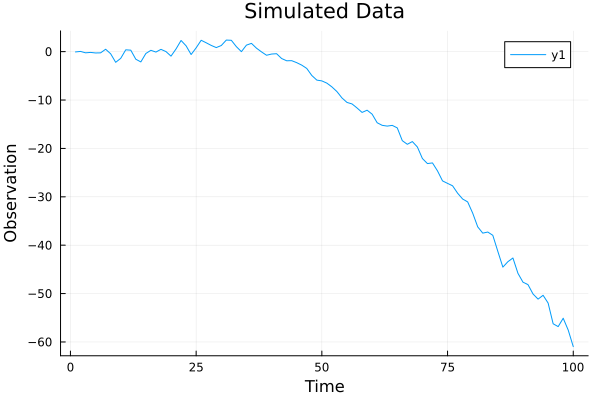

In [5]:
using Plots

plot(y, title="Simulated Data", xlabel="Time", ylabel="Observation")


## Estimate

In [6]:
#Define model
n_order = n_order
state_dim = 2 + 2 * n_order
alpha_init = zeros(state_dim)
alpha_init[1] = y[1]
P1 = Matrix{Float64}(I(state_dim))*100  # Initial covariance matrix

#Priors
a_rho = 0.01
b_rho = 0.97
a_lambda = 0.1
b_lambda = π
a_xi = 3
b_xi = 0.0005
a_kappa = 3
b_kappa = 0.01
a_epsilon = 3   
b_epsilon = 0.0005
priors = [a_rho, b_rho, a_lambda, b_lambda, a_xi, b_xi, a_kappa, b_kappa, a_epsilon, b_epsilon]




10-element Vector{Float64}:
 0.01
 0.97
 0.1
 3.141592653589793
 3.0
 0.0005
 3.0
 0.01
 3.0
 0.0005

In [ ]:
# Run MCMC initialization
chain_init_burned, Sigma, acceptance_rate_init, chain_init = initialize_mcmc(
    y,
    priors,
    alpha_init, 
    P1, 
    n_order; 
    n_init=40000, 
    burn_init=20000, 
    omega_init=0.03)


Initialization Phase 100%|███████████████████████████████| Time: 0:00:22


Initialization Acceptance Rate: 12.6275 %


([0.22142255047394643 -0.1722435066589172 … -4.61061331080411 -9.707419300159843; 0.22142255047394643 -0.1722435066589172 … -4.61061331080411 -9.707419300159843; … ; 0.3686475824628356 -0.1906053997303558 … -4.885244370298615 -8.640340275411722; 0.3686475824628356 -0.1906053997303558 … -4.885244370298615 -8.640340275411722], [0.011837201264544465 0.0017127775941740947 … -0.021604235203000973 -0.0005629697483327753; 0.0017127775941740947 0.0023047878340634706 … -0.005516847888630248 0.0001947179443976009; … ; -0.021604235203000973 -0.005516847888630248 … 0.07311481655272274 -0.0014512200633191939; -0.0005629697483327753 0.0001947179443976009 … -0.0014512200633191939 0.3060024292087753], 0.126275, [0.5429253534866914 1.4901455314874341 … 0.00994571662146603 6.083049695100052e-5; 0.5429253534866914 1.4901455314874341 … 0.00994571662146603 6.083049695100052e-5; … ; 0.5774868604476884 1.4762975413521908 … 0.00755727676239566 0.00017682672221854977; 0.5774868604476884 1.4762975413521908 … 0.

In [ ]:
parameters = ["rho", "lambda_c", "sigma_xi2", "sigma_kappa2", "sigma_epsilon2"]
n_params = length(parameters)


# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples_init = chain_init[:, i]
    
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples_init, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")

    
    # Add plots to the list
    push!(p_list, p2)
end

# Display the plots in a grid layout
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [8]:
# Run MCMC recursion
theta_samples_burned, alpha_samples, acceptance_rate_rec = recursion_mcmc(
    y, 
    priors,
    alpha_init, 
    P1, 
    n_order, 
    chain_init_burned, 
    Sigma; 
    n_rec=20000, 
    burn_rec=10000, 
    omega_rec=0.7)


Recursion Phase 100%|████████████████████████████████████| Time: 0:00:25


Recursion Acceptance Rate: 38.934999999999995 %


([0.5892436234401353 1.526718359911053 … 0.00940987760065069 0.0002612587050596927; 0.5892436234401353 1.526718359911053 … 0.00940987760065069 0.0002612587050596927; … ; 0.5632434197890679 1.5029953560362643 … 0.00931619130876914 0.00012057067012484957; 0.5632434197890679 1.5029953560362643 … 0.00931619130876914 0.00012057067012484957], Any[[-1.8182607249991953 0.38844007171501715 … 1.859496321317582 3.984489581349056; -1.429820653242711 0.3339680773738287 … 1.2008969624863148 1.1583812186980715; … ; -56.85975068524647 -1.100462484617399 … 1.7579689280591144 0.7863077038319569; -57.96021316986389 -1.0902589054877296 … 0.402881083579554 -1.8154079808195944], [2.0136679383549136 -0.594479213131315 … -1.9807015311257352 -2.681802120642616; 1.4191887251966335 -0.6734047025224541 … -1.6662945925439656 -0.8976716176679673; … ; -57.04687391087623 -1.3727077445233995 … 1.9342131952809134 1.0743635201010249; -58.419581655399725 -1.4591601280690867 … 0.8914288364777039 -1.6182340485698827], [-1.

In [9]:

# Initial guesses for parameters
initial_params = [0.5, 0.2, 0.5, 0.5, 0.5]

# Bounds for parameters
lower_bounds = [0.0, 0.0, 1e-6, 1e-6, 1e-6]
upper_bounds = [0.999, π, Inf, Inf, Inf]


# Define the objective function
function obj(params::Vector, grad::Vector)
    try
        return negative_log_likelihood(params, y, alpha_init, P1, n_order)
    catch e
        return 1e10  # Return a large number in case of error
    end
end

# Create the optimizer
opt = Opt(:LN_NELDERMEAD, length(initial_params))
opt.lower_bounds = lower_bounds
opt.upper_bounds = upper_bounds
opt.min_objective = obj
opt.maxeval = 1000
opt.xtol_rel = 1e-6

# Run the optimization
(minf, estimated_params, ret) = NLopt.optimize(opt, initial_params)

# Display the estimated parameters
println("Estimated Parameters: ", estimated_params)


Estimated Parameters: [0.5363337721912118, 1.452030349080714, 0.008790539993684895, 0.010705751984644418, 0.20075125040295733]


In [10]:
parameters = ["rho", "lambda_c", "sigma_xi2", "sigma_kappa2", "sigma_epsilon2"]
n_params = length(parameters)


5

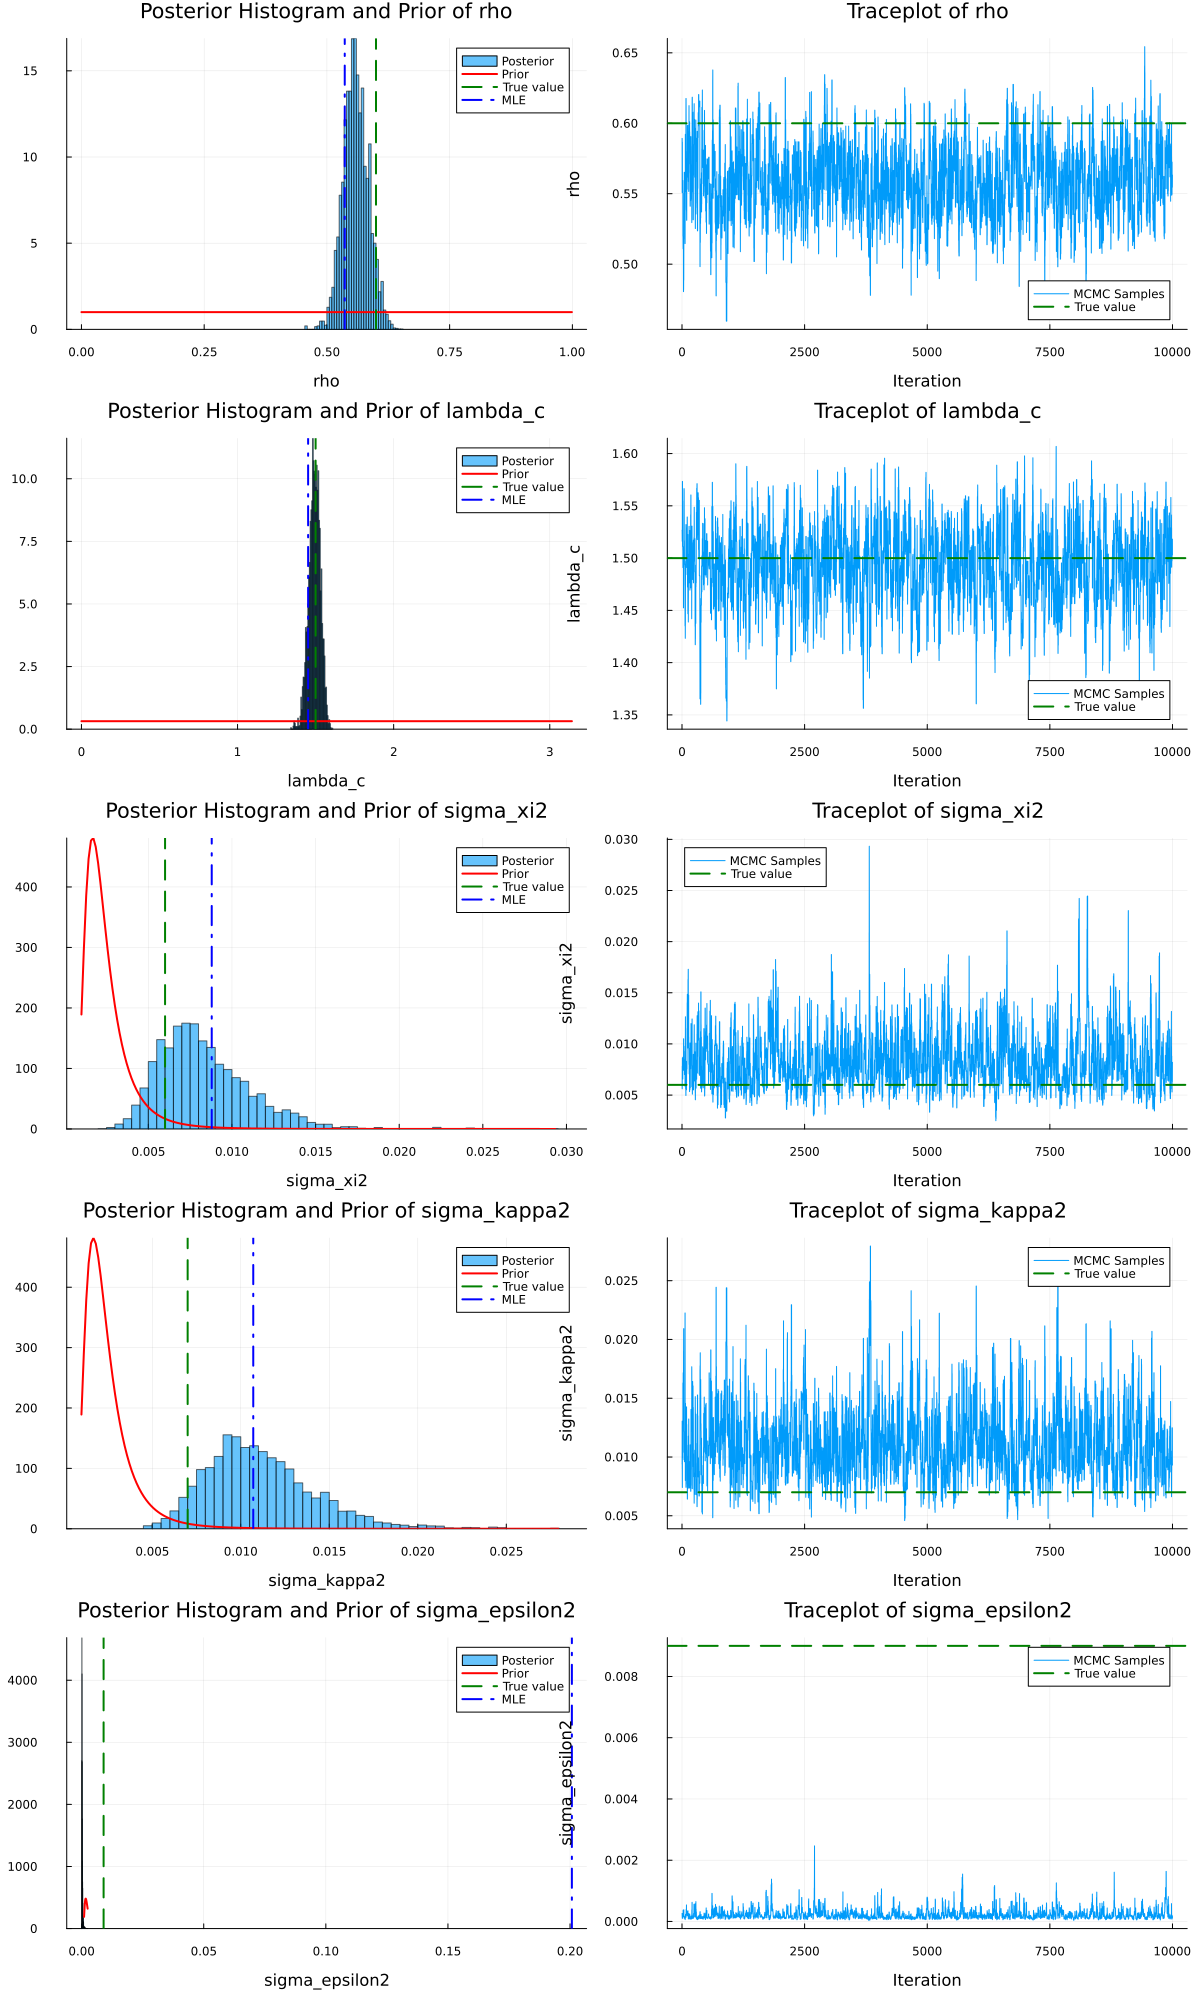

In [11]:
# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples = theta_samples_burned[:, i]
    
    # Histogram of posterior samples
    p1 = histogram(param_samples, bins=50, normalize=true, alpha=0.6,
                   label="Posterior", xlabel=parameters[i], ylabel="Density",
                   title="Posterior Histogram and Prior of $(parameters[i])")
    
    # Define the prior distribution
    if parameters[i] == "rho"
        # Uniform prior between 0 and 0.999
        a = 0.0
        b = 0.999
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] == "lambda_c"
        # Uniform prior between 0 and π
        a = 0.0
        b = π
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    else
        # Inverse-Gamma prior with a=3, b=1
        a_ig = 5.0
        b_ig = 0.01
        x_min = 0.001  # Avoid zero
        x_max = maximum(param_samples)
        x_values = range(x_min, x_max, length=200)
        prior_pdf = pdf.(InverseGamma(a_ig, b_ig), x_values)
    end
    
    # Overlay prior PDF on histogram
    plot!(p1, x_values, prior_pdf, label="Prior", color=:red, linewidth=2)
    
    # Include true parameter value
    vline!(p1, [params_true[i]], label="True value", color=:green, linestyle=:dash, linewidth=2)
    
    # If you have MLE estimates, include them (uncomment and define `estimated_params`)
    vline!(p1, [estimated_params[i]], label="MLE", color=:blue, linestyle=:dashdot, linewidth=2)
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")
    hline!(p2, [params_true[i]], label="True value", color=:green, linestyle=:dash, linewidth=2)
    
    # Add plots to the list
    push!(p_list, p1)
    push!(p_list, p2)
end

# Display the plots in a grid layout
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [12]:
# Calculate means of posterior samples
chain_rec_burned_means = mean(theta_samples_burned, dims=1)  # 1 x n_params array
chain_rec_burned_means = vec(chain_rec_burned_means)  # Convert to a vector


5-element Vector{Float64}:
 0.5589073065213892
 1.4933514551898381
 0.008324313844292617
 0.01111356870547103
 0.00022560834678641274

In [13]:

# Create the DataFrame
data = DataFrame(Dict(
    "Parameter" => parameters,
    "MCMC Estimate" => chain_rec_burned_means,
    "MLE Estimate" => estimated_params,  # Include if available
    "True Value" => params_true
))

# Display the DataFrame
display(data)


5×4 DataFrame
 Row │ MCMC Estimate  MLE Estimate  Parameter       True Value 
     │ Float64        Float64       String          Float64    
─────┼─────────────────────────────────────────────────────────
   1 │   0.558907       0.536334    rho                  0.6
   2 │   1.49335        1.45203     lambda_c             1.5
   3 │   0.00832431     0.00879054  sigma_xi2            0.006
   4 │   0.0111136      0.0107058   sigma_kappa2         0.007
   5 │   0.000225608    0.200751    sigma_epsilon2       0.009

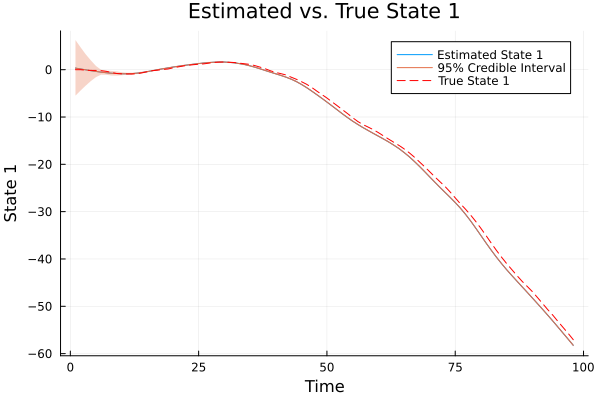

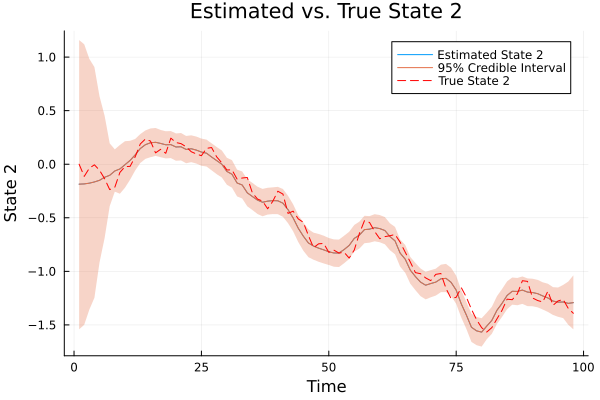

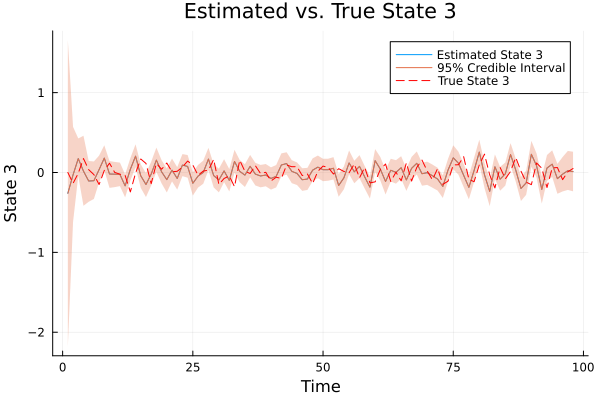

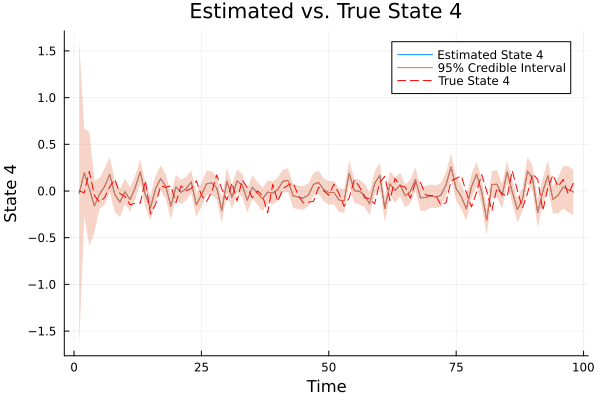

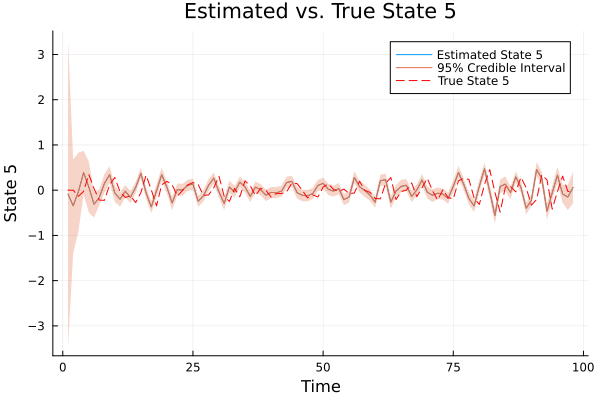

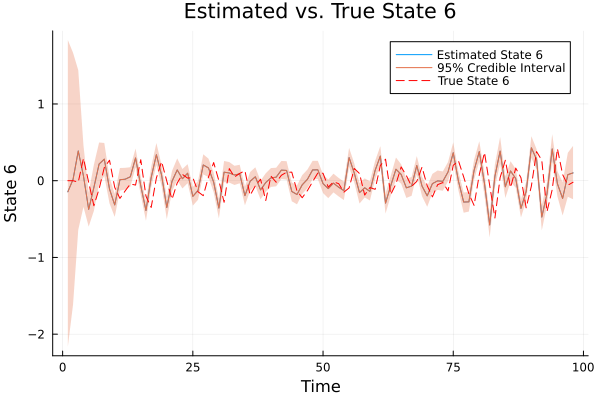

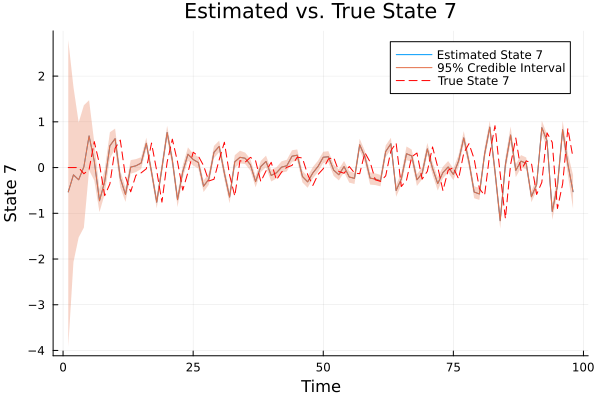

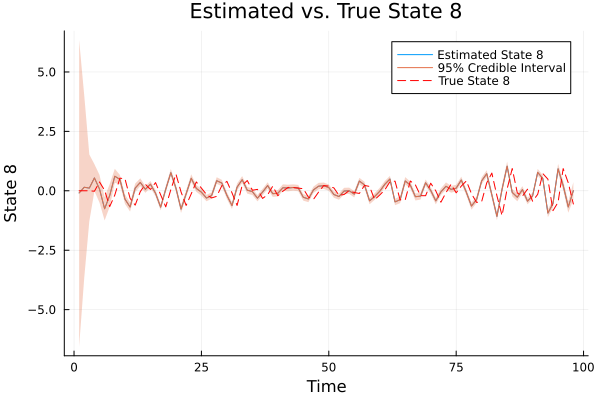

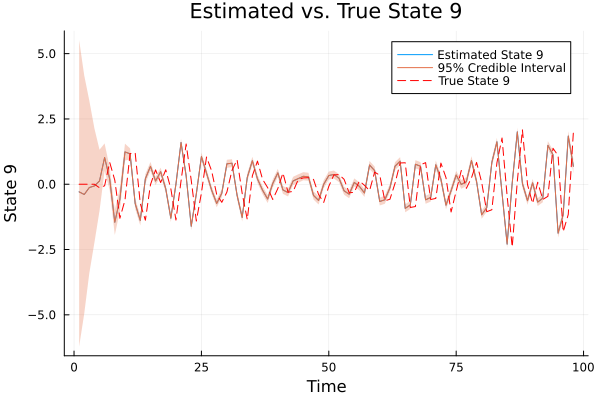

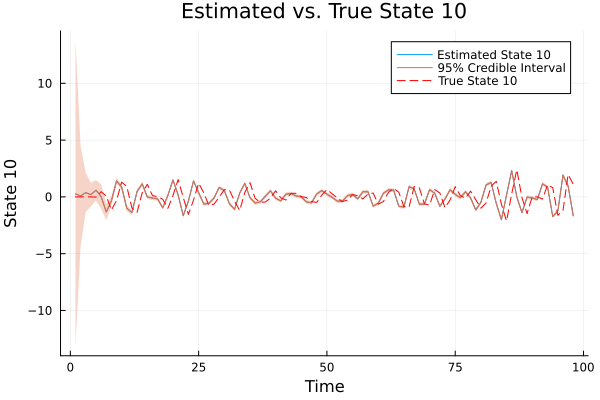

In [14]:
# Collect alpha samples into a 3D array
n_samples = length(alpha_samples)
n_time_steps = size(alpha_samples[1], 1)
state_dim = size(alpha_samples[1], 2)

# Initialize array to hold alpha samples
alpha_samples_array = Array{Float64}(undef, n_samples, n_time_steps, state_dim)

for i in 1:n_samples
    alpha_samples_array[i, :, :] = alpha_samples[i]
end


# Compute posterior mean over samples (dimension 1)
alpha_mean = mean(alpha_samples_array, dims=1)  # 1 x n_time_steps x state_dim
alpha_mean = dropdims(alpha_mean; dims=1)  # n_time_steps x state_dim

# Compute credible intervals
alpha_lower = mapslices(x -> quantile(x, 0.025), alpha_samples_array; dims=1)
alpha_lower = dropdims(alpha_lower; dims=1)
alpha_upper = mapslices(x -> quantile(x, 0.975), alpha_samples_array; dims=1)
alpha_upper = dropdims(alpha_upper; dims=1)



time = 1:n_time_steps

for s in 1:state_dim
    p = plot(time, alpha_mean[:, s], label="Estimated State $(s)", xlabel="Time",
             ylabel="State $(s)", title="Estimated vs. True State $(s)")
    
    # Add credible intervals using the `ribbon` argument
    plot!(time, alpha_mean[:, s], ribbon=(alpha_mean[:, s] .- alpha_lower[:, s],
          alpha_upper[:, s] .- alpha_mean[:, s]), fillalpha=0.3, label="95% Credible Interval")
    
    # Plot true state (assuming you have `alpha_true` from data simulation)
    plot!(time, alpha[1:n_time_steps, s], label="True State $(s)", linestyle=:dash, color=:red)
    
    display(p)
end


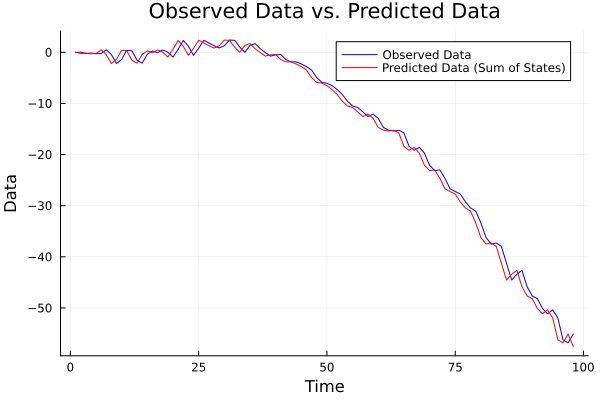

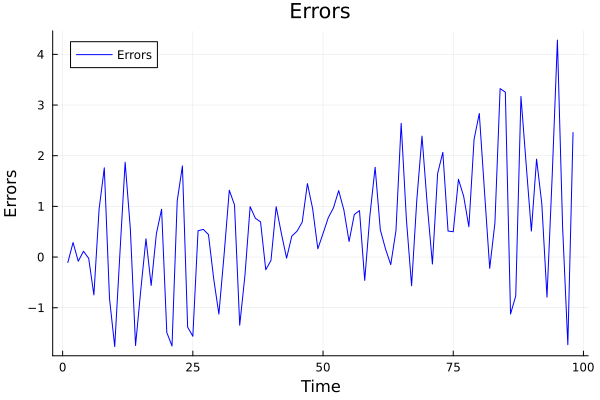

In [15]:
# Compute y_pred
# Adjust indices according to your state-space model
state_indices = [1, 2 + 2 * n_order-1]  

y_pred = alpha_mean[:, state_indices[1]] .+ alpha_mean[:, state_indices[2]]


# Adjust time and observed data if necessary
# If y_pred has fewer time points than y, adjust y accordingly
time = 1:length(y_pred)
y_adjusted = y[1:length(y_pred)]  # Adjust if lengths differ

p = plot(time, y_adjusted, label="Observed Data", color=:blue)
plot!(p, time, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Data")
display(p)


errors = y_adjusted .- y_pred

p_error = plot(time, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)
